<h1>Classification Model (Random Forest)<h1>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,precision_score,recall_score,f1_score,ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize, LabelEncoder
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE
import joblib

In [2]:
df = pd.read_csv("rwanda_students_final_v3.csv")
df.head()


,student_id,age,gender,school_type,location,math_score,english_score,science_score,history_score,attendance_rate,study_hours_per_week,parental_education_level,household_income,internet_access,recommended_stream,parental_career,extracurricular_activity,interest
0,S0001,18,Male,Private,Urban,88,81,98,71,83,21,Primary,9270,Yes,STEM,Technology,Sports,Humanities
1,S0002,19,Female,Public,Urban,80,63,55,48,70,28,Secondary,9603,Yes,Healthcare,Arts,NaN,Healthcare
2,S0003,17,Female,Private,Urban,41,45,54,77,59,24,Secondary,2860,No,Humanities,Healthcare,NaN,Healthcare
3,S0004,19,Male,Private,Urban,85,77,61,86,63,4,Secondary,7390,No,Healthcare,Technology,Entrepreneurship Club,Healthcare
4,S0005,19,Male,Public,Urban,61,90,91,51,64,21,Secondary,7226,No,Business,Technology,NaN,Business


In [3]:
df.shape

(1500, 18)

- Exploratory Data Analysis

In [4]:
print(df.isnull().sum()) #check for missing values

student_id                    0
age                           0
gender                        0
school_type                   0
location                      0
math_score                    0
english_score                 0
science_score                 0
history_score                 0
attendance_rate               0
study_hours_per_week          0
parental_education_level      0
household_income              0
internet_access               0
recommended_stream            0
parental_career               0
extracurricular_activity    288
interest                      0
dtype: int64


In [5]:
df.info() #dataset information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   student_id                1500 non-null   object
 1   age                       1500 non-null   int64 
 2   gender                    1500 non-null   object
 3   school_type               1500 non-null   object
 4   location                  1500 non-null   object
 5   math_score                1500 non-null   int64 
 6   english_score             1500 non-null   int64 
 7   science_score             1500 non-null   int64 
 8   history_score             1500 non-null   int64 
 9   attendance_rate           1500 non-null   int64 
 10  study_hours_per_week      1500 non-null   int64 
 11  parental_education_level  1500 non-null   object
 12  household_income          1500 non-null   int64 
 13  internet_access           1500 non-null   object
 14  recommended_stream      

In [6]:
df.duplicated().sum() #check for ant data duplicates

0

- Data preprocessing

- Visualizations

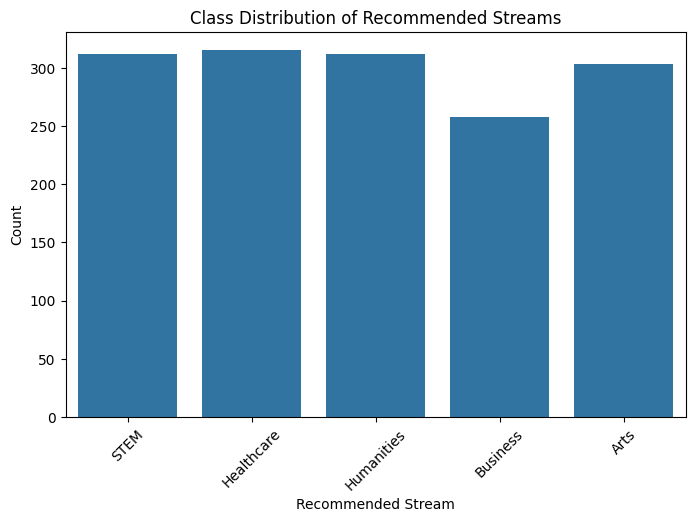

In [7]:
# 6. Visualize class distribution
plt.figure(figsize=(8,5))
sns.countplot(x=df["recommended_stream"])
plt.title("Class Distribution of Recommended Streams")
plt.xlabel("Recommended Stream")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

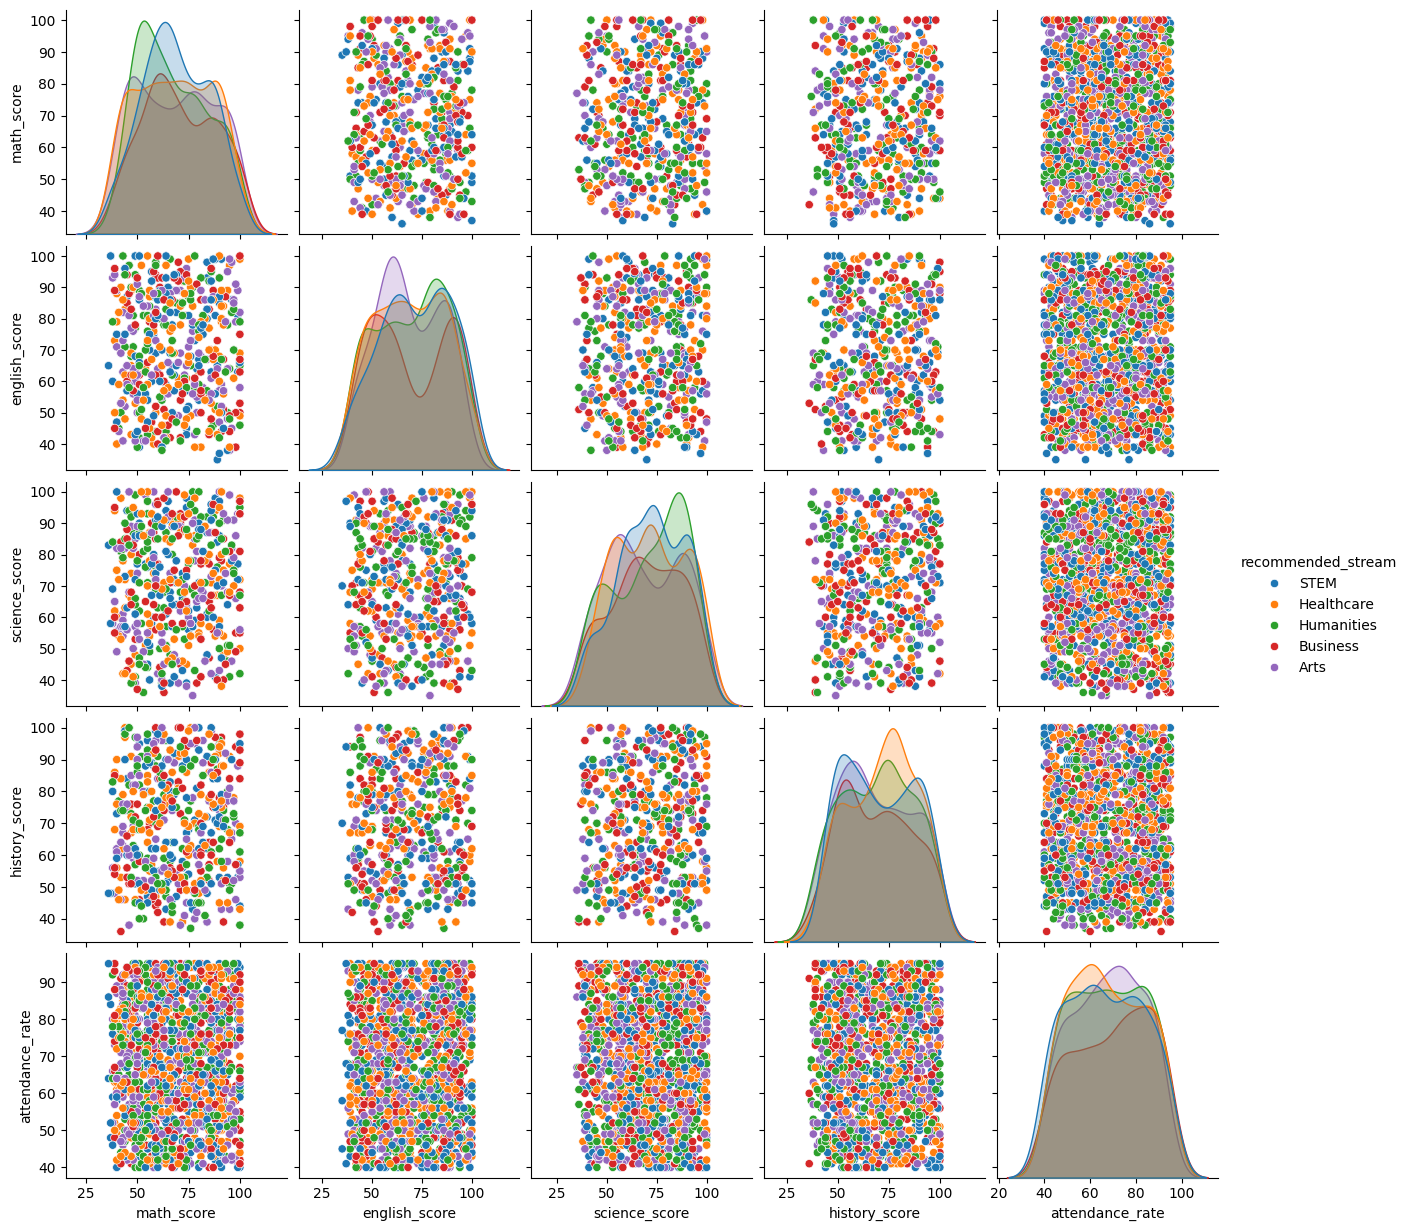

In [8]:
#selecting a subset of important numerical features for visualization
selected_features = ["math_score", "english_score", "science_score", "history_score", "attendance_rate"]

sns.pairplot(df[selected_features + ["recommended_stream"]], hue="recommended_stream", palette="tab10")
plt.show()

C:\Users\Hp\AppData\Local\Temp\ipykernel_3456\1595895984.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["recommended_stream"], y=df["attendance_rate"], palette="coolwarm")


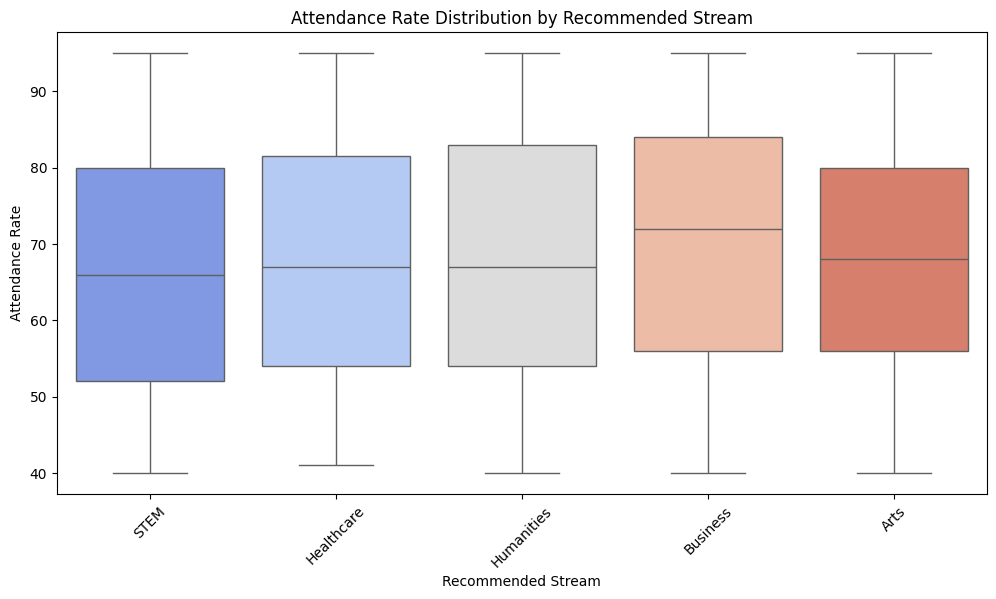

In [9]:
plt.figure(figsize=(12,6))

# Plot scores for each recommended stream
sns.boxplot(x=df["recommended_stream"], y=df["attendance_rate"], palette="coolwarm")
plt.title("Attendance Rate Distribution by Recommended Stream")
plt.xlabel("Recommended Stream")
plt.ylabel("Attendance Rate")
plt.xticks(rotation=45)
plt.show()

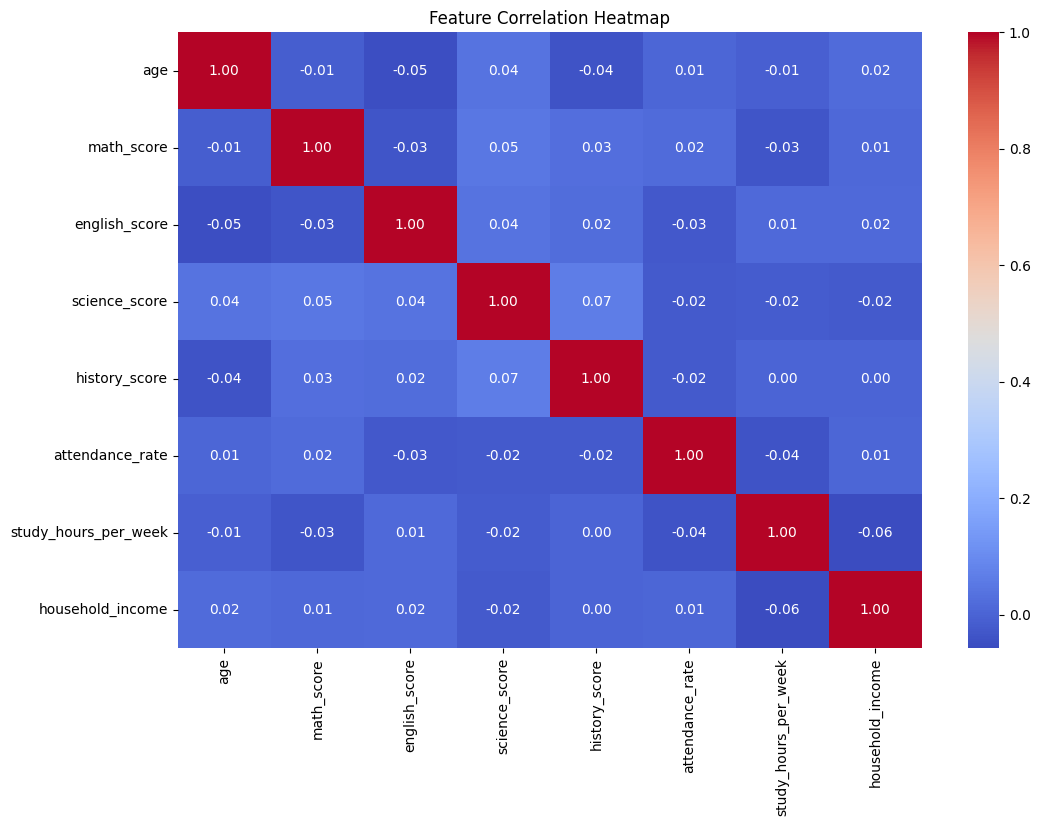

In [10]:
# 7. Correlation Heatmap (Numerical Features)
plt.figure(figsize=(12,8))

# Select only numeric columns
numeric_df = df.select_dtypes(include=[np.number])  # Excludes student_id and categorical strings

sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


- Data Preprocessing

In [11]:
df["extracurricular_activity"].fillna("None", inplace=True) #replace NaN with None

C:\Users\Hp\AppData\Local\Temp\ipykernel_3456\2876800846.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["extracurricular_activity"].fillna("None", inplace=True) #replace NaN with None


In [12]:
df.isna().sum()

student_id                  0
age                         0
gender                      0
school_type                 0
location                    0
math_score                  0
english_score               0
science_score               0
history_score               0
attendance_rate             0
study_hours_per_week        0
parental_education_level    0
household_income            0
internet_access             0
recommended_stream          0
parental_career             0
extracurricular_activity    0
interest                    0
dtype: int64

Using Label Encoding to treat categorical columns

In [13]:
categorical_cols = ["gender", "school_type", "location", "parental_education_level", 
                    "internet_access", "parental_career", "extracurricular_activity", 'interest', 'recommended_stream']
label_mappings = {}

for col in categorical_cols:
    encoder = LabelEncoder()
    df[col] = encoder.fit_transform(df[col])
    label_mappings[col] = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
    
joblib.dump(label_mappings, "label_mappings.pkl")

['label_mappings.pkl']

In [14]:
for col, mapping in label_mappings.items():
    print(f"Label mapping for {col}: {mapping}")

df.head()

Label mapping for gender: {'Female': 0, 'Male': 1}
Label mapping for school_type: {'Private': 0, 'Public': 1}
Label mapping for location: {'Rural': 0, 'Urban': 1}
Label mapping for parental_education_level: {'Primary': 0, 'Secondary': 1, 'Tertiary': 2}
Label mapping for internet_access: {'No': 0, 'Yes': 1}
Label mapping for parental_career: {'Arts': 0, 'Business': 1, 'Education': 2, 'Healthcare': 3, 'Technology': 4}
Label mapping for extracurricular_activity: {'Entrepreneurship Club': 0, 'Music': 1, 'None': 2, 'Science Club': 3, 'Sports': 4}
Label mapping for interest: {'Arts': 0, 'Business': 1, 'Healthcare': 2, 'Humanities': 3, 'STEM': 4}
Label mapping for recommended_stream: {'Arts': 0, 'Business': 1, 'Healthcare': 2, 'Humanities': 3, 'STEM': 4}


,student_id,age,gender,school_type,location,math_score,english_score,science_score,history_score,attendance_rate,study_hours_per_week,parental_education_level,household_income,internet_access,recommended_stream,parental_career,extracurricular_activity,interest
0,S0001,18,1,0,1,88,81,98,71,83,21,0,9270,1,4,4,4,3
1,S0002,19,0,1,1,80,63,55,48,70,28,1,9603,1,2,0,2,2
2,S0003,17,0,0,1,41,45,54,77,59,24,1,2860,0,3,3,2,2
3,S0004,19,1,0,1,85,77,61,86,63,4,1,7390,0,2,4,0,2
4,S0005,19,1,1,1,61,90,91,51,64,21,1,7226,0,1,4,2,1


In [15]:
x = df.drop(columns=["recommended_stream", "student_id"])
y = df["recommended_stream"]

In [16]:
# scaler = StandardScaler()
# x_scaled = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)

In [17]:
# df_scaled = pd.concat([x_scaled, y], axis=1)

# joblib.dump(scaler, "C:/Users/Hp/Desktop/system rec/model/scaler.pkl")
# df_scaled.head()

- Model Training

In [18]:
# x_final = df_scaled.drop(columns=["recommended_stream"])
# y_final = df_scaled["recommended_stream"]

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {x_train.shape}, Testing set: {x_test.shape}")


Training set: (1200, 16), Testing set: (300, 16)


In [27]:
x_train.head()

,age,gender,school_type,location,math_score,english_score,science_score,history_score,attendance_rate,study_hours_per_week,parental_education_level,household_income,internet_access,parental_career,extracurricular_activity,interest
652,15,1,1,1,75,71,60,99,64,20,1,7869,0,1,0,3
707,17,1,0,1,100,66,56,95,86,6,2,7536,0,1,4,2
979,19,0,1,0,71,41,68,94,94,25,0,2924,1,3,2,2
906,15,0,0,1,88,62,87,97,71,15,1,2928,1,2,2,4
591,15,1,1,0,51,39,90,59,43,21,2,8799,1,0,0,1


In [20]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(x_train, y_train)

RandomForestClassifier()

Create a final RandomForest model

- Model Evaluation

In [21]:
y_pred = rf_classifier.predict(x_test)
y_test_bin = label_binarize(y_test, classes=np.unique(y_test)) #binarize the output labels for multiclass
y_pred_bin = label_binarize(y_pred, classes=np.unique(y_test))

#compute AUC score
roc_auc = roc_auc_score(y_test_bin, y_pred_bin, average="weighted", multi_class="ovr")

#evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred).__round__(2))
print("Precision:", precision_score(y_test, y_pred, average='weighted').__round__(2))
print("Recall:", recall_score(y_test, y_pred, average='weighted').__round__(2))
print("F1-Score:", f1_score(y_test, y_pred, average='weighted').__round__(2))
print("Weighted ROC AUC Score:", roc_auc.__round__(2))

Accuracy: 0.92
Precision: 0.93
Recall: 0.92
F1-Score: 0.92
Weighted ROC AUC Score: 0.95


- Classification Report, Confusion Matrix, ROC AUC Curve

In [22]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.90      0.94        61
           1       1.00      0.88      0.94        52
           2       0.88      1.00      0.93        63
           3       0.92      0.95      0.94        62
           4       0.87      0.87      0.87        62

    accuracy                           0.92       300
   macro avg       0.93      0.92      0.92       300
weighted avg       0.93      0.92      0.92       300



<Figure size 800x600 with 0 Axes>

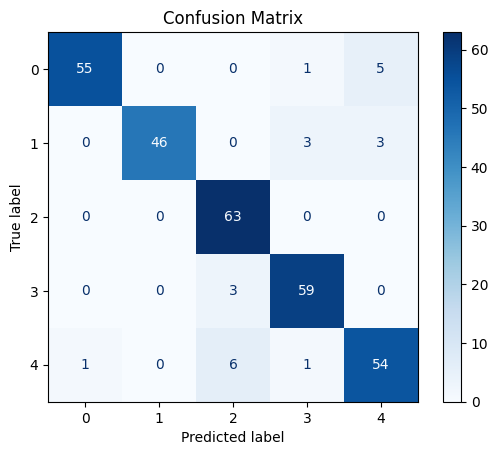

In [23]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.show()

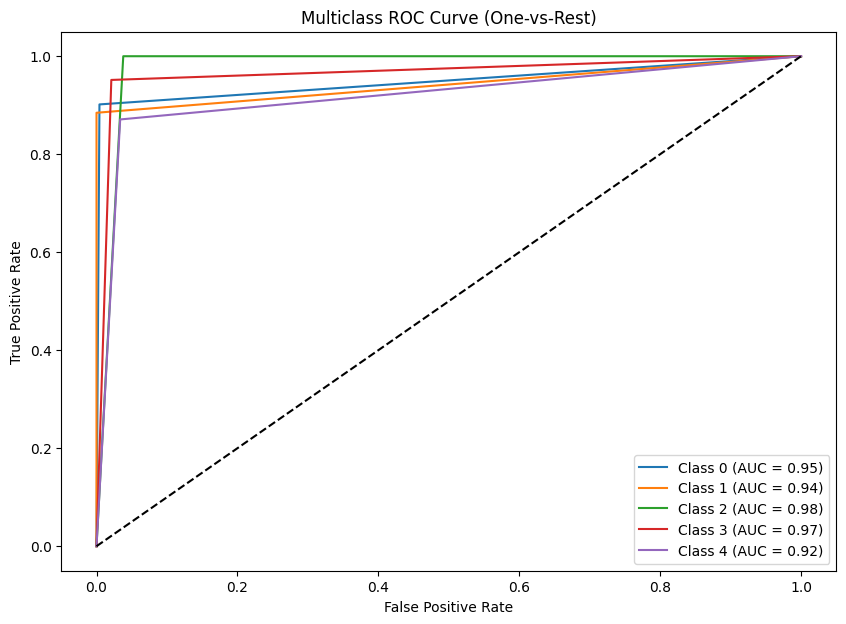

In [24]:
plt.figure(figsize=(10,7))
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {auc(fpr, tpr):.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve (One-vs-Rest)")
plt.legend()
plt.show()

In [25]:
rf_classifier.predict([x_train.iloc[9]])

c:\Users\Hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([1])

- Save the model

In [26]:
joblib.dump(rf_classifier, "random_forest_model.pkl")

['random_forest_model.pkl']